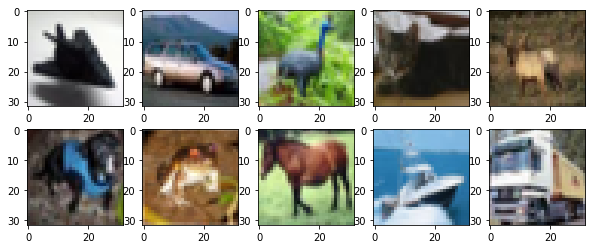

In [181]:
import cPickle as pickle
from  PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from collections import defaultdict

# get imgs for each class
f = open('/Users/fangtiantian/Documents/research/normalization/data/cifar-10-batches-py/data_batch_1', 'rb')

tupled_data= pickle.load(f)
f.close()
labels = tupled_data['labels']
img = tupled_data[b'data']


selected_imgs = []
selected_lables = []

for la in range(10):
    ind = labels.index(la)
    single_img = img[ind]
    single_img = np.transpose(np.reshape(single_img,(3, 32,32)), (1,2,0))
    selected_imgs.append(single_img)
    selected_lables.append(labels[ind])

# print selected_lables

fig=plt.figure(figsize=(10, 4))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img = selected_imgs[i-1]
    plt.imshow(img)
plt.show()

In [182]:
# k-means to cluster images
def quantize(raster, n_colors=32):
    width, height, depth = raster.shape
    reshaped_raster = np.reshape(raster, (width * height, depth))

    model = cluster.KMeans(n_clusters=n_colors)
    labels = model.fit_predict(reshaped_raster)
    palette = model.cluster_centers_.astype(int)
    quantized_raster = np.reshape(
        palette[labels], (width, height, palette.shape[1]))
    return quantized_raster, palette

# clus_img, colors_palette = (quantize(single_img_reshaped, 32))
# plt.imshow(clus_img)
# print clus_img

In [183]:
#It is referring to the clusters from k means. You want to reduce your image so it only has 32 possible colors 
# using k means. Then you go through each pixel using a bernoulli random variable. If its equal to 1 then you will
# sample uniformly from the cluster centers given from k means, else leave the color the same.

def add_noise(clus_img, colors_palette):
    noise_img = clus_img
    (h, w, _) = clus_img.shape
    for i in range(h):
        for j in range(w):
            p = bernoulli.rvs(1./32)
            if p == 1:
                # uniformly choose a color as noise
                noise_img[i,j] = colors_palette[np.random.randint(32)]
    return noise_img


# noise_img = add_noise(clus_img, colors_palette)
# plt.imshow(noise_img)
    


In [188]:
def compute_log_prob(X, Y, i, j, w_e, w_s):
    d = defaultdict(lambda: 0)
    pxy = multivariate_normal.pdf(Y[i,j]/255., mean=X[i,j]/255., cov=np.eye(3))
    d[tuple(X[i,j])] += w_e*pxy
    if i>0:
        pxy = multivariate_normal.pdf(Y[i,j]/255., mean=Y[i-1,j]/255., cov=np.eye(3))
        d[tuple(Y[i-1,j])] += w_s*pxy
    if i<X.shape[0]-1:
        pxy = multivariate_normal.pdf(Y[i,j]/255., mean=Y[i+1,j]/255., cov=np.eye(3))
        d[tuple(Y[i+1,j])] += w_s*pxy
    if j>0:
        pxy = multivariate_normal.pdf(Y[i,j]/255., mean=Y[i,j-1]/255., cov=np.eye(3))
        d[tuple(Y[i,j-1])] += w_s*pxy
    if j<X.shape[1]-1:
        pxy = multivariate_normal.pdf(Y[i,j]/255., mean=Y[i,j+1]/255., cov=np.eye(3))
        d[tuple(Y[i,j+1])] += w_s*pxy
    pred_color = np.array(max(d, key=d.get))
    return pred_color

In [192]:
def denoise_image(X, w_e, w_s):
    "X is observed, Y is prediction approx true value"
    m, n, _ = np.shape(X)
    # initialize Y same as X
    Y = np.copy(X)
    # optimization
    max_iter = 10*m*n
    for iter in range(max_iter):
    # randomly pick a location
        i = np.random.randint(m)
        j = np.random.randint(n)
        # compute the log probabilities of both values of Y_ij
        pred_color = compute_log_prob(X, Y, i, j, w_e, w_s)
        # assign Y_ij to the value with higher log probability
        Y[i, j] = pred_color
#         if iter % 100000 == 0:
#             print ('Completed', iter, 'iterations out of', max_iter)
    return Y

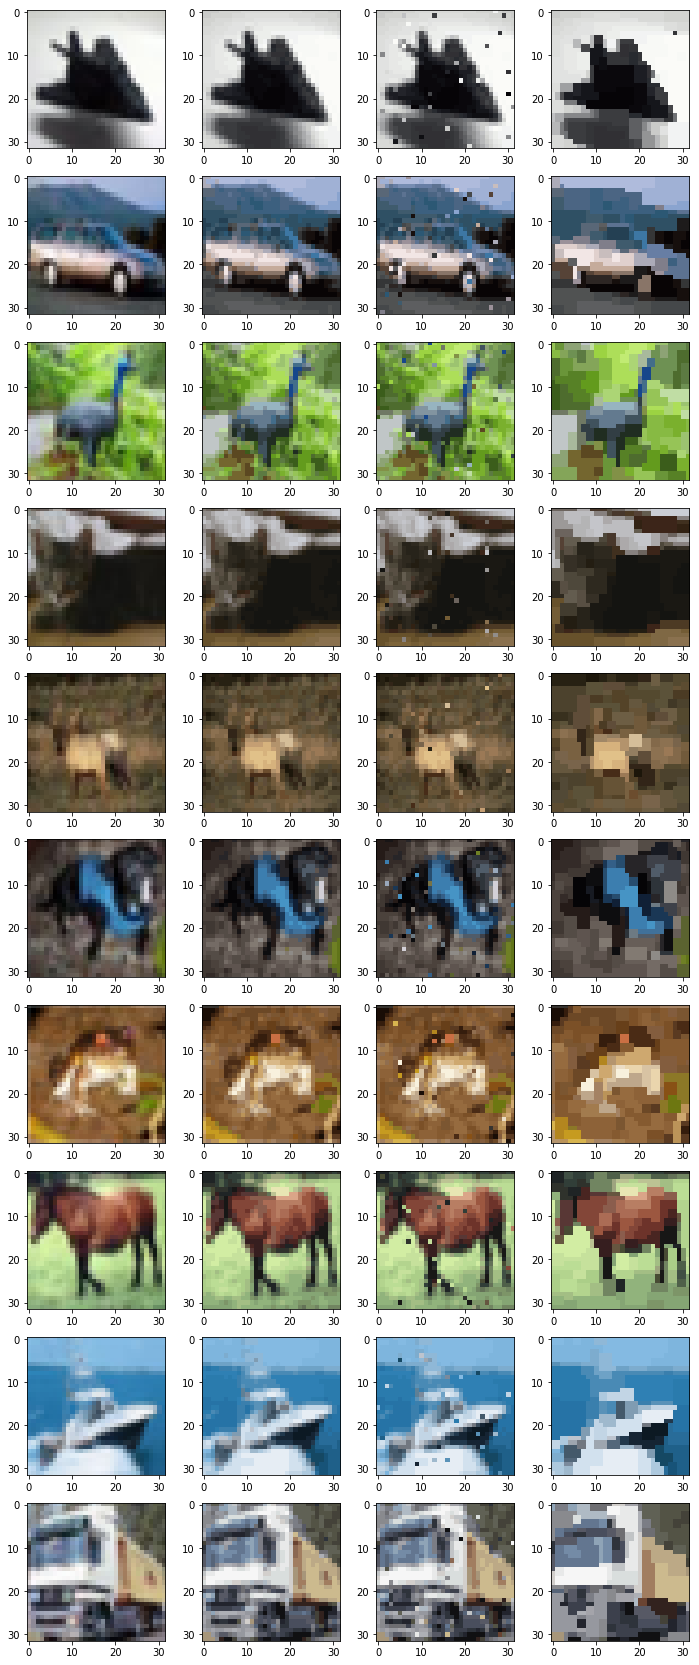

In [194]:
fig=plt.figure(figsize=(12, 30))
columns = 4
rows = 10
# for i in range(1, columns*rows +1):
#     fig.add_subplot(rows, columns, i)
#     img = selected_imgs[i-1]
#     plt.imshow(img)
# plt.show()


for i, im in enumerate(selected_imgs):
    # plot original img
    fig.add_subplot(rows, columns, i*4+1)
    plt.imshow(im)
    
    # plot clustered img
    clus_img, colors_palette = quantize(im)
    fig.add_subplot(rows, columns, i*4+2)
    plt.imshow(clus_img)
    
    #add noise and plot
    noise_img = add_noise(clus_img, colors_palette)
    fig.add_subplot(rows, columns, i*4+3)
    plt.imshow(noise_img)
    
    # denoise and plot
    clean_img = denoise_image(noise_img, 1, 1.5)
    fig.add_subplot(rows, columns, i*4+4)
    plt.imshow(clean_img)
    

plt.show()


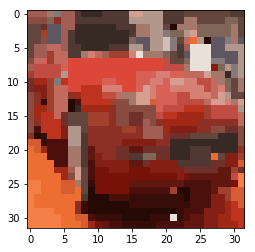

In [175]:
plt.imshow(clean)

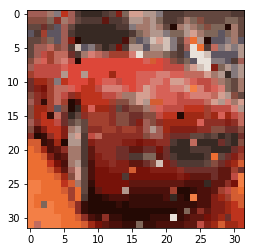

In [154]:
plt.imshow(noise_img)

In [ ]:
# reference : https://blog.statsbot.co/probabilistic-graphical-models-tutorial-d855ba0107d1